In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
ALGORITHMS = ['MORL-D(MOSAC)-SB+PSA', 'MORL-D(MOSAC)-SB', 'GPI-PD Continuous Action', 'GPI-LS Continuous Action', 'PGMORL', 'CAPQL', 'PCN continuous action']
ENVIRONMENTS = {
    "MOHopperDR-v5": ["MOHopperDefault-v5","MOHopperLight-v5","MOHopperHeavy-v5","MOHopperSlippery-v5","MOHopperLowDamping-v5","MOHopperHard-v5"],
    "MOHalfCheetahDR-v5": ["MOHalfCheetahDefault-v5","MOHalfCheetahLight-v5","MOHalfCheetahHeavy-v5","MOHalfCheetahSlippery-v5","MOHalfCheetahHard-v5"],
    "MOHumanoidDR-v5": ["MOHumanoidDefault-v5","MOHumanoidLight-v5","MOHumanoidHeavy-v5","MOHumanoidLowDamping-v5","MOHumanoidHard-v5"],
    "MOLunarLanderDR-v0": ["MOLunarLanderDefault-v0","MOLunarLanderHighGravity-v0","MOLunarLanderWindy-v0","MOLunarLanderTurbulent-v0","MOLunarLanderHard-v0"],
}
ALGORITHMS_NAME_MAP = {
    'PCN continuous action': 'PCN',
    'PGMORL': 'PGMORL',
    'CAPQL': 'CAPQL',
    'GPI-LS Continuous Action': 'GPI-LS',
    'GPI-PD Continuous Action': 'GPI-PD',
    'MORL-D(MOSAC)-SB': 'MORL-D(SB)',
    'MORL-D(MOSAC)-SB+PSA': 'MORL-D(SB+PSA)',
}

colors = sns.color_palette('colorblind')
ALGORITHMS_COLOR_MAP = {
    'CAPQL': colors[0],
    'GPI-LS': colors[3],
    'GPI-PD': colors[4],
    'MORL-D(SB)': colors[2],
    'MORL-D(SB+PSA)': colors[1],
    'PGMORL': colors[7],
    'PCN': colors[8],
}
SEEDS = [5,26,47,76,92]

ENVIRONMENT_NAME = "MOHopperDR-v5"
METRIC = "normalized_hypervolume"

In [4]:
def load_scores(env_id, algorithms, seeds, metric):
    envs = ENVIRONMENTS[env_id]
    scores = {}
    for algorithm in algorithms:
        algorithm_name = ALGORITHMS_NAME_MAP[algorithm]
        scores[algorithm_name] = {}
        for env in envs:
            for seed in seeds:
                df = pd.read_csv(f"data/scores/{env_id}/{algorithm}/seed_{seed}.csv")
                metric_values = df[metric + f"/{env}"].values
                scores[algorithm_name].setdefault(env, []).extend(metric_values)
    return scores

def convert_to_matrix(score_dict):
    keys = sorted(list(score_dict.keys()))
    return np.stack([score_dict[k] for k in keys], axis=1)

In [5]:
scores_dict = load_scores(ENVIRONMENT_NAME, ALGORITHMS, SEEDS, METRIC)
for algo in scores_dict.keys():
    scores_dict[algo] = convert_to_matrix(scores_dict[algo])
scores_dict

{'MORL-D(SB+PSA)': array([[0.52374617, 0.31401624, 0.39533433, 0.46598426, 0.54313199,
         0.40636352],
        [0.51854666, 0.26970823, 0.33664341, 0.40726907, 0.52974195,
         0.37559089],
        [0.44926239, 0.26904086, 0.33604571, 0.3732892 , 0.4528109 ,
         0.37970746],
        [0.57462975, 0.26781394, 0.40964082, 0.46563237, 0.57452931,
         0.41881893],
        [0.58018143, 0.25178034, 0.38318128, 0.46662216, 0.58667301,
         0.41506727]]),
 'MORL-D(SB)': array([[0.38379349, 0.2121129 , 0.23958967, 0.28878667, 0.38476049,
         0.26708241],
        [0.41112622, 0.18924298, 0.26006238, 0.33782925, 0.42764357,
         0.15684172],
        [0.4452734 , 0.22781868, 0.2665791 , 0.33703573, 0.45184043,
         0.30748667],
        [0.41903072, 0.20055229, 0.19155979, 0.32167112, 0.41918761,
         0.19292783],
        [0.39702734, 0.2315844 , 0.24709097, 0.32327622, 0.41027234,
         0.13374007]]),
 'GPI-PD': array([[0.50752851, 0.28529295, 0.36226699,

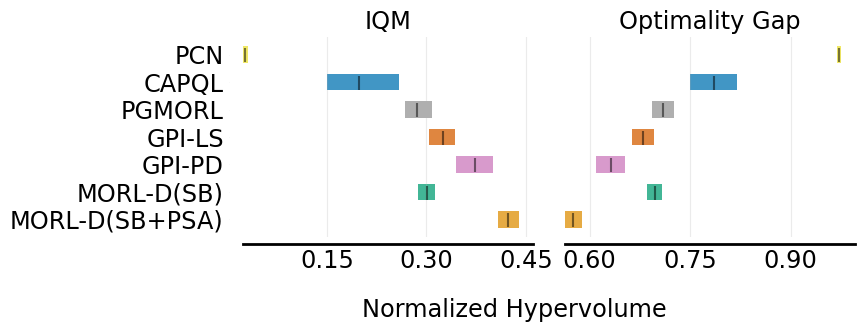

In [10]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

IQM = lambda x: metrics.aggregate_iqm(x)                    # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(x, 1.0)     # Optimality Gap

aggregate_func = lambda x: np.array([IQM(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    scores_dict, aggregate_func, reps=50000)

fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['IQM', 'Optimality Gap'],
    algorithms=list(scores_dict.keys()),
    colors=ALGORITHMS_COLOR_MAP,
    xlabel_y_coordinate=-0.2,
    xlabel='Normalized Hypervolume')

plt.savefig(f'images/{ENVIRONMENT_NAME}_IQM_OG.png', format='png', bbox_inches='tight')
plt.show()

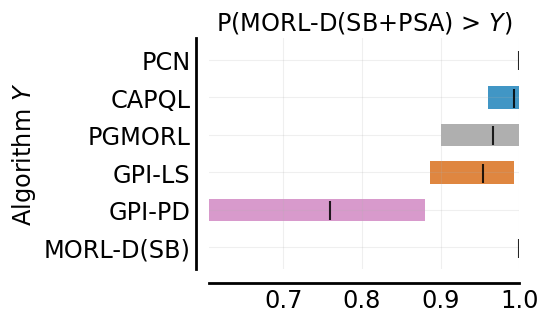

In [11]:
from matplotlib.ticker import MaxNLocator

all_pairs = {}
best_algo = 'MORL-D(SB+PSA)'
for alg_y in (scores_dict.keys()):
  if alg_y == best_algo:
    continue
  pair_name = f'{best_algo},{alg_y}'
  all_pairs[pair_name] = (scores_dict[best_algo], scores_dict[alg_y]) 

probabilities, probability_cis = {}, {}
probabilities, probability_cis = rly.get_interval_estimates(all_pairs, metrics.probability_of_improvement, reps=2000)

fig, ax = plt.subplots(figsize=(4, 3))
h = 0.6
algorithm_labels = []

for i, (alg_pair, prob) in enumerate(probabilities.items()):
  _, alg1 = alg_pair.split(',')
  algorithm_labels.append(alg1)
  (l, u) = probability_cis[alg_pair]
  ax.barh(y=i, width=u-l, height=h, left=l, color=ALGORITHMS_COLOR_MAP[alg1], alpha=0.75)
  ax.vlines(x=prob, ymin=i-7.5 * h/16, ymax=i+(6*h/16), color='k', alpha=0.85)
ax.set_yticks(range(len(algorithm_labels)))
ax.set_yticklabels(algorithm_labels)


ax.set_title(fr'P({best_algo} > $Y$)', size='xx-large')
plot_utils._annotate_and_decorate_axis(ax, labelsize='xx-large', ticklabelsize='xx-large')
ax.set_ylabel(r'Algorithm $Y$', size='xx-large')
ax.xaxis.set_major_locator(MaxNLocator(4))
fig.subplots_adjust(wspace=0.25, hspace=0.45)

plt.savefig(f'images/{ENVIRONMENT_NAME}_PROB_IMPROVEMENT.png', format='png', bbox_inches='tight')
plt.show()